##  Corrélation entre variation du prix du Bitcoin et nombre de M&M's par paquets au cours du temps

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

couleurs = [
    "jaune ",
    "rouge ",
    "bleu ",
    "vert ",
    "marron ",
    "orange ",
]  # l'espace est nécessaire car comme ca dans le fichier csv
dico_correlation = {}


### 1- Gestion des données, création des Data Frame (tableau de donnée)

Je vais créer deux tableaux :
- 'mnms' avec les données des M&m's 
- 'bitcoin' avec les données du bitcoin trouvées sur le site 'CoinMarketCap'

In [41]:
# Data Frame pour les M&M's

mnms = pd.read_csv("Données_M&Ms.csv", sep=",")
mnms["date "] = pd.to_datetime(mnms["date "], format="%d/%m/%Y")
mnms["date "] = mnms["date "].dt.strftime(
    "%d-%m-%Y"
)  # pour mettre les dates dans le bon format


J'ai modifié la manière dont la date est représentée pour aider dans la suite.

In [42]:
# Data Frame pour le Bitcoin

tableau = pd.read_csv(
    "vrai_données_bitcoin.csv", sep=";"
)
tableau["timeOpen"] = pd.to_datetime(tableau["timeOpen"])
tableau["prix_moyen"] = tableau[["open", "high", "low", "close"]].mean(
    axis=1
)  # Calcul du prix moyen de la journée
tableau["diff_ouv_ferm"] = tableau["close"]-tableau["open"]
bitcoin = tableau[
    ["timeOpen", "prix_moyen","diff_ouv_ferm"]
]  # Créer un DataFrame avec seulement la date et le prix moyen
bitcoin["timeOpen"] = bitcoin["timeOpen"].dt.strftime(
    "%d-%m-%Y"
)  # Reformater la date en DD-MM-YYYY
bitcoin = bitcoin.rename(
    columns={"timeOpen": "date "}
)  # renommage de la colonne pour la jointure
print(bitcoin)

           date     prix_moyen  diff_ouv_ferm
0     21-10-2025  94786.056246   -1460.596409
1     20-10-2025  94052.652046    1767.988059
2     19-10-2025  92527.164555    1243.656793
3     18-10-2025  91682.260116     640.436611
4     17-10-2025  91414.883067   -1161.174984
...          ...           ...            ...
2793  25-02-2018   7889.886354    -103.286393
2794  24-02-2018   8184.523800    -386.097684
2795  23-02-2018   8222.232980     315.806408
2796  22-02-2018   8467.767377    -565.582061
2797  21-02-2018   8928.506196    -513.210233

[2798 rows x 3 columns]


C:\Users\Tiphaine MPCI\AppData\Local\Temp\ipykernel_29024\1084497532.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin["timeOpen"] = bitcoin["timeOpen"].dt.strftime(


Je garde uniquement la colonne date et une colonne reservée au prix moyen d'un bitcoin sur la journée.

### 2- Création de dictionnaire de corrélation

Ce dictionnaire aura 6 clés pour chaque couleur de M&M's. Les valeurs seront un tableau correspondant à la jointure à droite entre 'bitcoin' et 'mnms' avec la condition 'date égale'. Ainsi avec cette jointure, chaque couleur possède un tableau (dont les colonnes sont [date, prixBitcoin, diff_ouc_ferm, nombreM&M's]), et ce dernier va me permettre de vérifier si il y a corrélation ou non entre les varitations du prix du Bitcoin et les variations d'occurence de la couleur dans les paquets.

In [43]:
for coul in couleurs:
    jointure = pd.merge(
        bitcoin, mnms[["date ", coul]], on="date ", how="right"
    )  # Jointure de bitcoin et mnms sur la colonne 'date'
    dico_correlation[coul] = jointure

for coul in couleurs:
    X_prix = np.array(dico_correlation[coul]["prix_moyen"])  # vecteur des prix
    x_diff = np.array(dico_correlation[coul]["diff_ouv_ferm"])  # vecteur des diff
    X_nbrcouleur = np.array(
        dico_correlation[coul][coul]
    )  # vecteur du nombre de présence de cette couleur dans le paquet
    X_date = np.array(dico_correlation[coul]["date "])  # vecteur date
    dico_correlation[coul] = {
        "date": X_date,
        "prix": X_prix,
        "diff": x_diff,
        "nombre": X_nbrcouleur,
    }

### 3- Étude de possibles corrélations

#### 3.1 - calcul des coefficients de corrélations

On sait que le coefficient de corrélation entre $X$ et $Y$, deux vecteurs de taille $n$ est égal à $\frac{\text{cov}(X, Y)}{\sqrt{\text{var}(X)} \sqrt{\text{var}(Y)}}
$

avec $
\text{cov}(X, Y) = \frac{1}{n+1} \sum_{i=0}^{n} (x_i - \overline{X})(y_i - \overline{Y})
$, 


$
\text{var}(Y) = \frac{1}{n+1} \sum_{i=0}^{n} (y_i - \overline{Y})^2
$, 

$
\overline{Y} = \frac{1}{n+1} \sum_{i=0}^{n} y_i
$, 

$
\text{var}(X) = \frac{1}{n+1} \sum_{i=0}^{n} (x_i - \overline{X})^2
$ et 

$
\overline{X} = \frac{1}{n+1} \sum_{i=0}^{n} x_i
$,

On calcule donc cela pour $X1$ : le nombre de M&M's et $X2$ le prix du Bitcoin soit :

In [44]:
#coefficient de corrélation 

coeffprime = ('', 0)
for coul in dico_correlation:
    X1 = dico_correlation[coul]['nombre']
    X2 = dico_correlation[coul]['prix']
    X1bar = 1/X1.size*np.sum(X1) #valeur moyenne du vecteur X1 (les nombres de couleurs par paquets)
    X2bar = 1/X2.size*np.sum(X2) #valeur moyenne du vecteur X2 (le prix du bitcoin à la date de l'ouverture du paquet)
    varX1 = 1/X1.size*np.sum((X1-X1bar)**2) #la variance de X1
    varX2 = 1/X2.size*np.sum((X2-X2bar)**2) 
    cov = 1/X1.size*np.sum((X1-X1bar)*(X2-X2bar)) #la covariance cov(X1, X2)
    coeff = cov/(np.sqrt(varX2)*np.sqrt(varX1))
    if np.abs(coeff) > np.abs(coeffprime[1]) : #vérification si amélioration du coeff
        coeffprime = (coul, coeff)
    print("le coeff de corrélation de", coul, "est :", coeff)

print("le meilleur coeff de corrélation est :", coeffprime[1], "pour la couleur :", coeffprime[0])


le coeff de corrélation de jaune  est : -0.11933259770838624
le coeff de corrélation de rouge  est : -0.004871608789324451
le coeff de corrélation de bleu  est : -0.1408862694198275
le coeff de corrélation de vert  est : -0.0377712427001283
le coeff de corrélation de marron  est : -0.09406575363846799
le coeff de corrélation de orange  est : -0.17171967574287803
le meilleur coeff de corrélation est : -0.17171967574287803 pour la couleur : orange 


In [45]:
coeffprime = ('', 0)
for coul in dico_correlation:
    X1 = dico_correlation[coul]['nombre']
    X2 = dico_correlation[coul]['diff']
    X1bar = 1/X1.size*np.sum(X1) #valeur moyenne du vecteur X1 (les nombres de couleurs par paquets)
    X2bar = 1/X2.size*np.sum(X2) #valeur moyenne du vecteur X2 (le prix du bitcoin à la date de l'ouverture du paquet)
    varX1 = 1/X1.size*np.sum((X1-X1bar)**2) #la variance de X1
    varX2 = 1/X2.size*np.sum((X2-X2bar)**2) 
    cov = 1/X1.size*np.sum((X1-X1bar)*(X2-X2bar)) #la covariance cov(X1, X2)
    coeff = cov/(np.sqrt(varX2)*np.sqrt(varX1))
    if np.abs(coeff) > np.abs(coeffprime[1]) : #vérification si amélioration du coeff
        coeffprime = (coul, coeff)
    print("le coeff de corrélation de", coul, "est :", coeff)

print("le meilleur coeff de corrélation pour diff est :", coeffprime[1], "pour la couleur :", coeffprime[0])

le coeff de corrélation de jaune  est : -0.0005712875730599384
le coeff de corrélation de rouge  est : 0.04700800642519387
le coeff de corrélation de bleu  est : -0.02012609945904355
le coeff de corrélation de vert  est : 0.027940087422564583
le coeff de corrélation de marron  est : 0.033974443933743
le coeff de corrélation de orange  est : -0.01872474603599198
le meilleur coeff de corrélation pour diff est : 0.04700800642519387 pour la couleur : rouge 


Les coefficients sont très mauvais (le meilleur est de -0.17 pour les oranges, alors qu'on cherche un coeff proche en valeur absolue de 1). Je peux maintenant essayer de décaler les échelles de temps pour peut-être visualiser une meilleure corrélation, par exemple si la présence d'orange dans une paquet à la date $t$ influence le bitcoin uniquement à la date $t+10$. 

#### 3.2 - Calcul des coefficients de corrélations à délai 


Je vais, pour chaque décalage de $+1$ jour à $+150$ jours, déterminer 'dico_correlation' et calculer les différents coeff. J'afficherai le meilleur en notant bien pour quel décalage et pour quelle couleur.

In [51]:
#création de nouvelle Data Frame car on va les modifier

mnms2 = pd.read_csv("Données_M&Ms.csv", sep=",")
mnms2["date "] = pd.to_datetime(mnms2["date "], format="%d/%m/%Y")
mnms2["date "] = mnms2["date "].dt.strftime(
    "%d-%m-%Y"
)

tableau2 = pd.read_csv(
    "vrai_données_bitcoin.csv", sep=";"
)
tableau2["timeOpen"] = pd.to_datetime(tableau2["timeOpen"])
tableau2["prix_moyen"] = tableau2[["open", "high", "low", "close"]].mean(
    axis=1
)  # Calcul du prix moyen de la journée
tableau2["diff_ouv_ferm"] = tableau["close"]-tableau["open"]
bitcoin2 = tableau2[
    ["timeOpen", "prix_moyen","diff_ouv_ferm"]
]  # Créer un DataFrame avec seulement la date et le prix moyen
bitcoin2["timeOpen"] = bitcoin2["timeOpen"].dt.strftime(
    "%d-%m-%Y"
)  # Reformater la date en DD-MM-YYYY
bitcoin2 = bitcoin2.rename(
    columns={"timeOpen": "date "}
)  # renommage de la colonne pour la jointure





C:\Users\Tiphaine MPCI\AppData\Local\Temp\ipykernel_29024\1938915563.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin2["timeOpen"] = bitcoin2["timeOpen"].dt.strftime(


In [ ]:
# tentative de décalage de l'échelle de temps pour trouver des corrélations à délai

coeffprime2 = {'délai':0, 'couleur' : '', 'valeur':0}

for i in range(1, 150):
    copie_bitcoin2 = bitcoin2.copy()
    # Décaler le prix moyen d'un jour vers le haut
    copie_bitcoin2["prix_moyen_t+i"] = copie_bitcoin2["prix_moyen"].shift(-i)
    # Garder uniquement les colonnes utiles
    resultat = copie_bitcoin2[["date ", "prix_moyen_t+i"]]

    dico_correlation2 = {}
    for coul in couleurs:
        jointure = pd.merge(
            resultat, mnms2[["date ", coul]], on="date ", how="right"
        )  # Jointure de bitcoin et mnms sur la colonne 'date'
        dico_correlation2[coul] = jointure
        # print('taille de la jointure', len(jointure))
    # print(jointure.head())
    for coul in couleurs :
        X_prix = np.array(dico_correlation2[coul]["prix_moyen_t+i"]) # vecteur des prix
        X_nbrcouleur = np.array(dico_correlation2[coul][coul]) # vecteur du nombre de présence de cette couleur dans le paquet
        X_date = np.array(dico_correlation2[coul]['date ']) # vecteur date
        dico_correlation2[coul] = {'date': X_date, 'prix': X_prix, 'nombre' : X_nbrcouleur}

    coeffprime_i = {'couleur': '', 'valeur': 0} # calcul du meilleur coefficient entre les couleurs pour la corrélation correspondante au délai i
    for coul in dico_correlation2:
        X1 = dico_correlation2[coul]['prix']
        X2 = dico_correlation2[coul]['nombre']
        X1bar = 1/X1.size*np.sum(X1) 
        X2bar = 1/X2.size*np.sum(X2)
        varX1 = 1/X1.size*np.sum((X1-X1bar)**2)
        varX2 = 1/X2.size*np.sum((X2-X2bar)**2)
        cov = 1/X1.size*np.sum((X1-X1bar)*(X2-X2bar))
        coeff = cov/(np.sqrt(varX2)*np.sqrt(varX1))
        if np.abs(coeff) > coeffprime[1] :
            coeffprime_i['couleur'] = coul
            coeffprime_i['valeur'] = coeff
    if np.abs(coeffprime_i['valeur']) > np.abs(coeffprime2['valeur']) : #vérification si amélioration de la valeur du coeff global
        coeffprime2['valeur'] = coeffprime_i['valeur']
        coeffprime2['couleur'] = coeffprime_i['couleur']
        coeffprime2['délai'] = i

    
print("le meilleur coeff de corrélation est :", coeffprime2['valeur'], "pour la couleur :", coeffprime2['couleur'], "et le délai :", coeffprime2['délai'] )

le meilleur coeff de corrélation est : -0.17599732643831842 pour la couleur : orange  et le délai : 144


In [ ]:
# tentative de décalage de l'échelle de temps pour trouver des corrélations à délai

coeffprime2 = {'délai':0, 'couleur' : '', 'valeur':0}

for i in range(1, 150):
    copie_bitcoin2 = bitcoin2.copy()
    # Décaler le prix moyen d'un jour vers le haut
    copie_bitcoin2["diff_ouv_ferm_t+i"] = copie_bitcoin2["diff_ouv_ferm"].shift(-i)
    # Garder uniquement les colonnes utiles
    resultat = copie_bitcoin2[["date ", "diff_ouv_ferm_t+i"]]

    dico_correlation2 = {}
    for coul in couleurs:
        jointure = pd.merge(
            resultat, mnms2[["date ", coul]], on="date ", how="right"
        )  # Jointure de bitcoin et mnms sur la colonne 'date'
        dico_correlation2[coul] = jointure
        # print('taille de la jointure', len(jointure))
    # print(jointure.head())
    for coul in couleurs :
        X_diff = np.array(dico_correlation2[coul]["diff_ouv_ferm_t+i"]) # vecteur des diff des prix entre le début de la journée et la fin de la journée
        X_nbrcouleur = np.array(dico_correlation2[coul][coul]) # vecteur du nombre de présence de cette couleur dans le paquet
        X_date = np.array(dico_correlation2[coul]['date ']) # vecteur date
        dico_correlation2[coul] = {'date': X_date, 'diff': X_diff, 'nombre' : X_nbrcouleur}

    coeffprime_i = {'couleur': '', 'valeur': 0} # calcul du meilleur coefficient entre les couleurs pour la corrélation correspondante au délai i
    for coul in dico_correlation2:
        X1 = dico_correlation2[coul]['diff']
        X2 = dico_correlation2[coul]['nombre']
        X1bar = 1/X1.size*np.sum(X1) 
        X2bar = 1/X2.size*np.sum(X2)
        varX1 = 1/X1.size*np.sum((X1-X1bar)**2)
        varX2 = 1/X2.size*np.sum((X2-X2bar)**2)
        cov = 1/X1.size*np.sum((X1-X1bar)*(X2-X2bar))
        coeff = cov/(np.sqrt(varX2)*np.sqrt(varX1))
        if np.abs(coeff) > coeffprime[1] :
            coeffprime_i['couleur'] = coul
            coeffprime_i['valeur'] = coeff
    if np.abs(coeffprime_i['valeur']) > np.abs(coeffprime2['valeur']) : #vérification si amélioration de la valeur du coeff global
        coeffprime2['valeur'] = coeffprime_i['valeur']
        coeffprime2['couleur'] = coeffprime_i['couleur']
        coeffprime2['délai'] = i

    
print("le meilleur coeff de corrélation est :", coeffprime2['valeur'], "pour la couleur :", coeffprime2['couleur'], "et le délai :", coeffprime2['délai'] )

le meilleur coeff de corrélation est : -0.14280496027078066 pour la couleur : orange  et le délai : 314


C'est toujours pas du tout ce que j'attends. (A noter que si le coeff était de 1 en valeur absolue, la vie avec les M&M's deviendrait complètement simple...).


### 4- Visualisation des deux jeux de données, régression linéaire

Affichons les M&M's orange par exemple et le cours du Bitcoin en fonction du temps pour comprendre pourquoi le coeff de corrélation est si bas.

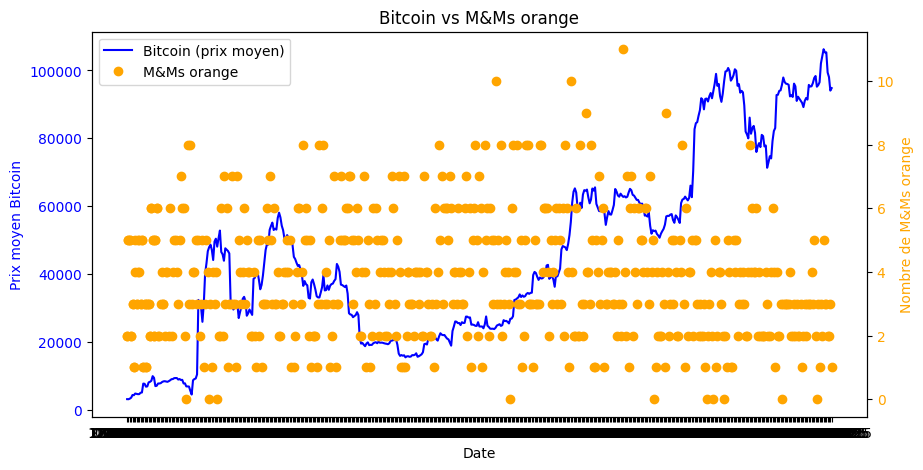

In [48]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Axe Y pour le Bitcoin
ax1.plot(dico_correlation['orange ']["date"], dico_correlation['orange ']["prix"], color="blue", label="Bitcoin (prix moyen)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Prix moyen Bitcoin", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Axe Y secondaire pour les M&Ms
ax2 = ax1.twinx()
ax2.plot(dico_correlation['orange ']["date"], dico_correlation['orange ']["nombre"], 'o', color="orange", label="M&Ms orange")
ax2.set_ylabel("Nombre de M&Ms orange", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Ajouter une légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Bitcoin vs M&Ms orange")
plt.show()

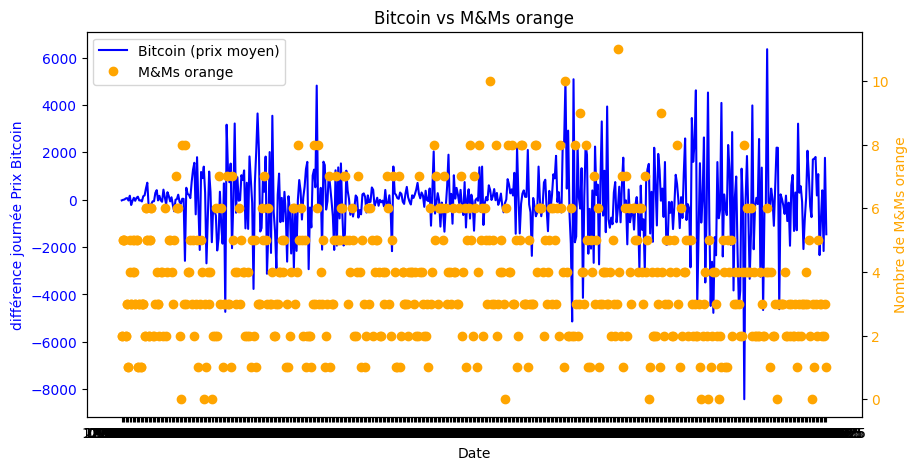

In [56]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Axe Y pour le Bitcoin
ax1.plot(dico_correlation['orange ']["date"], dico_correlation['orange ']["diff"], color="blue", label="Bitcoin (prix moyen)")
ax1.set_xlabel("Date")
ax1.set_ylabel("différence journée Prix Bitcoin", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Axe Y secondaire pour les M&Ms
ax2 = ax1.twinx()
ax2.plot(dico_correlation['orange ']["date"], dico_correlation['orange ']["nombre"], 'o', color="orange", label="M&Ms orange")
ax2.set_ylabel("Nombre de M&Ms orange", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Ajouter une légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Bitcoin vs M&Ms orange")
plt.show()

De plus, on peut afficher la droite affine de régression linéaire du nombre de M&M's en fonction du prix (l'inverse rend quelque chose d'ignoble) grâce à la fonction linregress du module scipy.stats. (toujours pour la couleur orange)

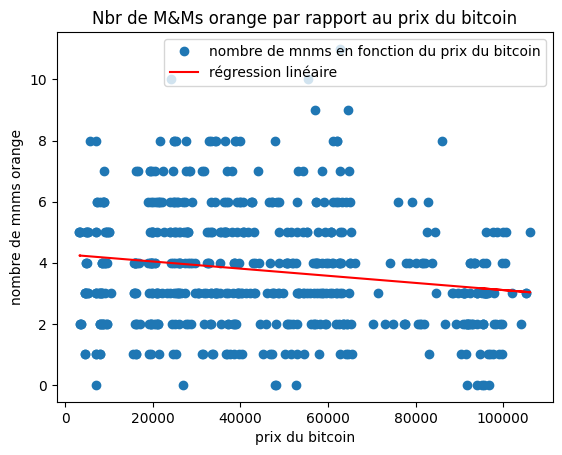

In [49]:
#régression linéaire

u1, u0, rho, p, stderr = linregress(dico_correlation['orange ']['prix'], dico_correlation['orange ']['nombre'])

plt.figure()
plt.title('Nbr de M&Ms orange par rapport au prix du bitcoin')
plt.xlabel("prix du bitcoin")
plt.ylabel("nombre de mnms orange")
plt.plot(dico_correlation['orange ']['prix'], dico_correlation['orange ']['nombre'], 'o', label = 'nombre de mnms en fonction du prix du bitcoin')
plt.plot(dico_correlation['orange ']['prix'], u0 + u1 * dico_correlation['orange ']['prix'], 'r-', label='régression linéaire')
plt.legend()
plt.show()

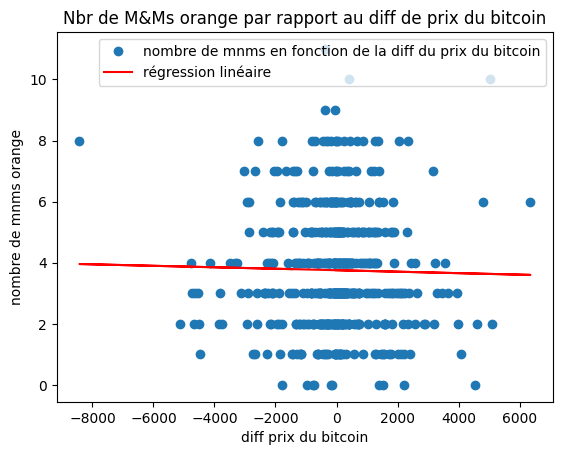

In [58]:
#régression linéaire

u1, u0, rho, p, stderr = linregress(dico_correlation['orange ']['diff'], dico_correlation['orange ']['nombre'])

plt.figure()
plt.title('Nbr de M&Ms orange par rapport au diff de prix du bitcoin')
plt.xlabel("diff prix du bitcoin")
plt.ylabel("nombre de mnms orange")
plt.plot(dico_correlation['orange ']['diff'], dico_correlation['orange ']['nombre'], 'o', label = 'nombre de mnms en fonction de la diff du prix du bitcoin')
plt.plot(dico_correlation['orange ']['diff'], u0 + u1 * dico_correlation['orange ']['diff'], 'r-', label='régression linéaire')
plt.legend()
plt.show()

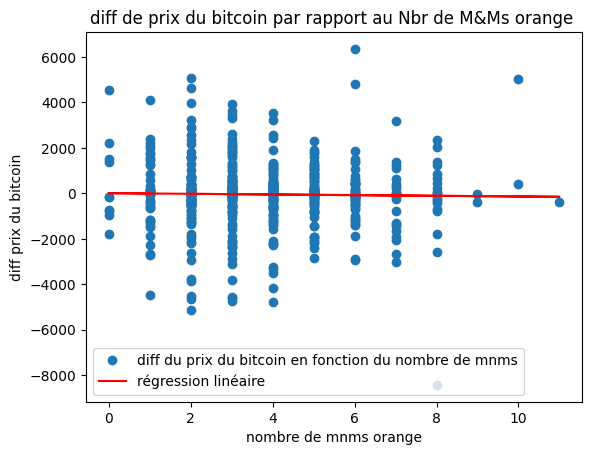

In [63]:
#régression linéaire

u1, u0, rho, p, stderr = linregress(dico_correlation['orange ']['nombre'], dico_correlation['orange ']['diff'])

plt.figure()
plt.title('diff de prix du bitcoin par rapport au Nbr de M&Ms orange ')
plt.ylabel("diff prix du bitcoin")
plt.xlabel("nombre de mnms orange")
plt.plot(dico_correlation['orange ']['nombre'], dico_correlation['orange ']['diff'], 'o', label = 'diff du prix du bitcoin en fonction du nombre de mnms')
plt.plot(dico_correlation['orange ']['nombre'], u0 + u1 * dico_correlation['orange ']['nombre'], 'r-', label='régression linéaire')
plt.legend()
plt.show()

On remaque une pente négative, ce qui explique les valeurs négatives de coefficient de corrélation. Le nombre de M&M's orange a donc tendance à diminuer lorsque le prix du Bitcoin augmente. Mais bon au vue du coefficients de corrélations, je conseille à personne de miser en bourse à l'aide d'un paquet de M&M's.